# DEMETER2 in Stan

In [1]:
import pystan
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import arviz as az
from pathlib import Path
import seaborn as sns
from timeit import default_timer as timer
import warnings
import re
from notebook_modules.pystan_helpers import StanModel_cache

plt.style.use('seaborn-whitegrid')
plt.rcParams['figure.figsize'] = (10.0, 7.0)
plt.rcParams['axes.titlesize'] = 18
plt.rcParams['axes.labelsize'] = 15

modeling_data_dir = Path('../modeling_data')

warnings.filterwarnings(action='ignore', 
                        message='Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won\'t be used')

## Data preparation

In [2]:
modeling_data = pd.read_csv(modeling_data_dir / 'subset_modeling_data.csv')
modeling_data.head()

barcode_sequence                     cell_line       lfc  batch  \
0  ACAGAAGAAATTCTGGCAGAT  ln215_central_nervous_system  1.966515      1   
1  ACAGAAGAAATTCTGGCAGAT  ln382_central_nervous_system  1.289606      1   
2  ACAGAAGAAATTCTGGCAGAT                   efo21_ovary  0.625725      1   
3  ACAGAAGAAATTCTGGCAGAT           jhesoad1_oesophagus  1.392272      1   
4  ACAGAAGAAATTCTGGCAGAT          km12_large_intestine  0.820838      1   

  gene_symbol  
0        EIF6  
1        EIF6  
2        EIF6  
3        EIF6  
4        EIF6

## Exploratory data analysis

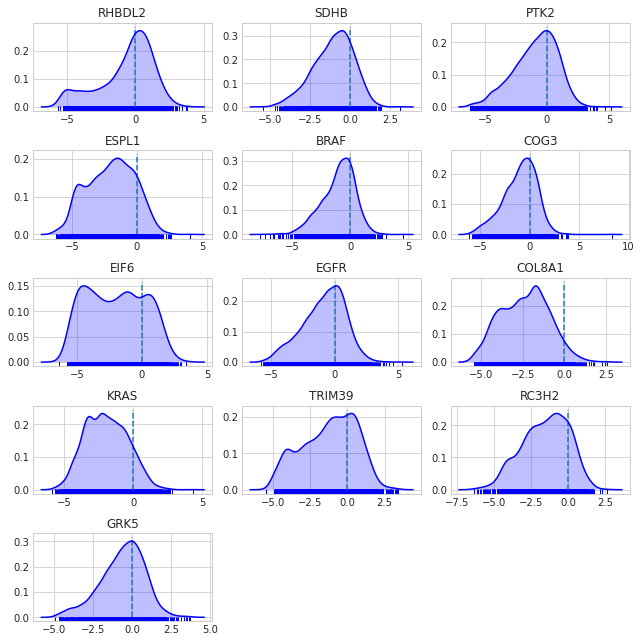

In [3]:
genes = set(modeling_data.gene_symbol.to_list())
fig, axes = plt.subplots(5, 3, figsize=(9, 9))
for ax, gene in zip(axes.flat, genes):
    lfc = modeling_data[modeling_data.gene_symbol == gene].lfc
    sns.distplot(lfc, kde=True, hist=False, rug=True, ax=ax, kde_kws={'shade': True}, color='b')
    
    y_data = ax.lines[0].get_ydata()
    ax.vlines(x=0, ymin=0, ymax=np.max(y_data) * 1.05, linestyles='dashed')
    
    ax.set_title(gene, fontsize=12)
    ax.set_xlabel(None)


axes[4, 2].axis('off')
axes[4, 1].axis('off')
fig.tight_layout(pad=1.0)
plt.show()

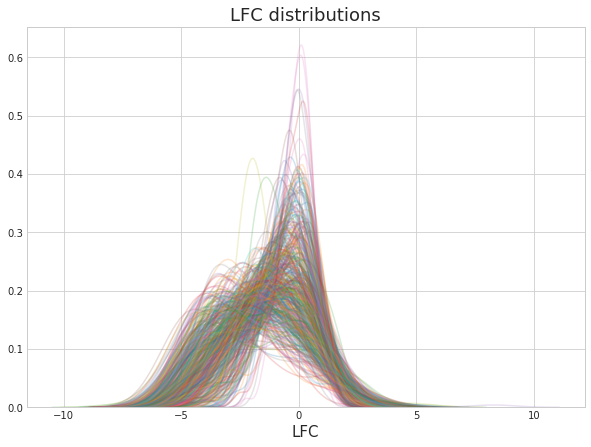

In [4]:
cell_lines = set(modeling_data.cell_line.to_list())
for cell_line in cell_lines:
    lfc = modeling_data[modeling_data.cell_line == cell_line].lfc
    sns.distplot(lfc, kde=True, hist=False, label=None, kde_kws={'alpha': 0.2})

plt.title('LFC distributions')
plt.xlabel('LFC')
plt.show()

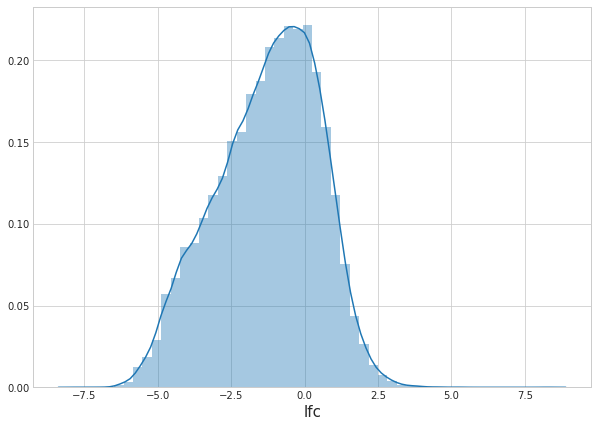

In [5]:
sns.distplot(modeling_data.lfc)
plt.show()

In [6]:
modeling_data[['barcode_sequence', 'gene_symbol']].drop_duplicates().groupby('gene_symbol').count()

barcode_sequence
gene_symbol                  
BRAF                        8
COG3                        5
COL8A1                      5
EGFR                       19
EIF6                        5
ESPL1                       5
GRK5                        5
KRAS                       11
PTK2                       23
RC3H2                       4
RHBDL2                      5
SDHB                        5
TRIM39                      9

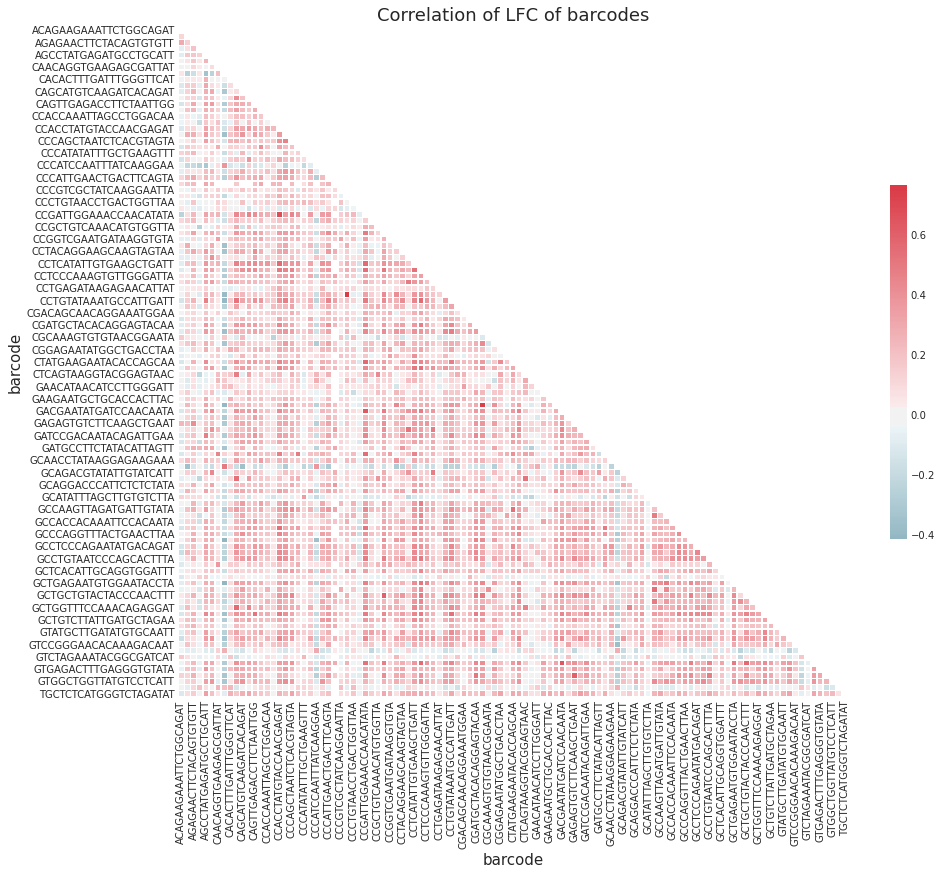

In [7]:
lfc_corr = modeling_data \
    .pivot(index='cell_line', columns='barcode_sequence', values='lfc') \
    .corr()

mask = np.triu(np.ones_like(lfc_corr, dtype=np.bool), k=0)
f, ax = plt.subplots(figsize=(15, 13))
cmap = sns.diverging_palette(220, 10, as_cmap=True)
sns.heatmap(lfc_corr, mask=mask, 
            cmap=cmap, center=0, 
            square=True, linewidths=0.5, cbar_kws={'shrink': 0.5})
plt.xlabel('barcode')
plt.ylabel('barcode')
plt.title('Correlation of LFC of barcodes')
plt.show()

## Modeling

In [8]:
models_dir = Path('..', 'models')

In [9]:
modeling_data.head()

barcode_sequence                     cell_line       lfc  batch  \
0  ACAGAAGAAATTCTGGCAGAT  ln215_central_nervous_system  1.966515      1   
1  ACAGAAGAAATTCTGGCAGAT  ln382_central_nervous_system  1.289606      1   
2  ACAGAAGAAATTCTGGCAGAT                   efo21_ovary  0.625725      1   
3  ACAGAAGAAATTCTGGCAGAT           jhesoad1_oesophagus  1.392272      1   
4  ACAGAAGAAATTCTGGCAGAT          km12_large_intestine  0.820838      1   

  gene_symbol  
0        EIF6  
1        EIF6  
2        EIF6  
3        EIF6  
4        EIF6

Select only a few cell lines while model building.

In [10]:
len(np.unique(modeling_data.cell_line))

501

In [11]:
np.random.seed(123)
cell_lines = np.random.choice(np.unique(modeling_data.cell_line), 40)
modeling_data = modeling_data[modeling_data.cell_line.isin(cell_lines)]
modeling_data.shape

(3334, 5)

In [12]:
np.unique(modeling_data.gene_symbol)

array(['BRAF', 'COG3', 'COL8A1', 'EGFR', 'EIF6', 'ESPL1', 'GRK5', 'KRAS',
       'PTK2', 'RC3H2', 'RHBDL2', 'SDHB', 'TRIM39'], dtype=object)

In [13]:
# model_testing_genes = ['COG3', 'KRAS', 'COL8A1', 'EIF6']
# modeling_data = modeling_data[modeling_data.gene_symbol.isin(model_testing_genes)]

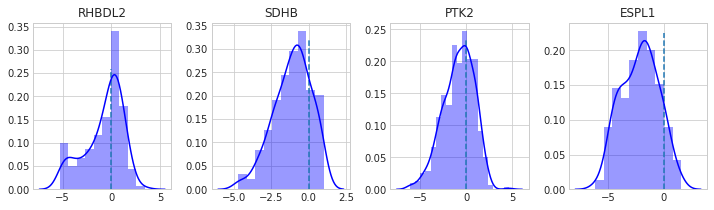

In [14]:
genes = set(modeling_data.gene_symbol.to_list())
fig, axes = plt.subplots(1, 4, figsize=(10, 3))
for ax, gene in zip(axes.flat, genes):
    lfc = modeling_data[modeling_data.gene_symbol == gene].lfc
    sns.distplot(lfc, kde=True, hist=True, ax=ax, color='b')
    
    y_data = ax.lines[0].get_ydata()
    ax.vlines(x=0, ymin=0, ymax=np.max(y_data) * 1.05, linestyles='dashed')
    
    ax.set_title(gene, fontsize=12)
    ax.set_xlabel(None)

fig.tight_layout(pad=1.0)
plt.show()

In [15]:
def add_categorical_idx(df, col):
    df[f'{col}_idx'] = df[col].astype('category').cat.codes + 1
    return df

for col in ['barcode_sequence', 'cell_line', 'gene_symbol']:
    modeling_data = add_categorical_idx(modeling_data, col)

modeling_data = modeling_data.reset_index(drop=True)
modeling_data.head()

barcode_sequence                         cell_line       lfc  batch  \
0  ACAGAAGAAATTCTGGCAGAT                       efo21_ovary  0.625725      1   
1  ACAGAAGAAATTCTGGCAGAT  dbtrg05mg_central_nervous_system  2.145082      2   
2  ACAGAAGAAATTCTGGCAGAT                       bt20_breast  0.932751      2   
3  ACAGAAGAAATTCTGGCAGAT     sw1783_central_nervous_system  1.372030      2   
4  ACAGAAGAAATTCTGGCAGAT      kns60_central_nervous_system  0.803835      2   

  gene_symbol  barcode_sequence_idx  cell_line_idx  gene_symbol_idx  
0        EIF6                     1             11                5  
1        EIF6                     1              9                5  
2        EIF6                     1              3                5  
3        EIF6                     1             36                5  
4        EIF6                     1             18                5

Binary matrix of $[shRNA \times gene]$.

In [16]:
shrna_gene_matrix = modeling_data[['barcode_sequence_idx', 'gene_symbol_idx']] \
    .drop_duplicates() \
    .reset_index(drop=True) \
    .assign(value = lambda df: np.ones(df.shape[0], dtype=int)) \
    .pivot(index='barcode_sequence_idx', columns='gene_symbol_idx', values='value') \
    .fillna(0) \
    .to_numpy() \
    .astype(int)

shrna_gene_matrix

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 1]])

In [17]:
shrna_gene_matrix.shape

(109, 13)

## Model 1. Just an intercept

$$
D \sim N(\mu, \sigma) \\
\mu = \alpha \\
\alpha \sim N(0, 5) \\
\sigma \sim \text{HalfCauchy}(0, 5)
$$

**Model data.**

In [18]:
d2_m1_data = {
    'N': int(modeling_data.shape[0]),
    'y': modeling_data.lfc
}

**Compile model.**

In [19]:
d2_m1_file = models_dir / 'd2_m1.cpp'
d2_m1 = StanModel_cache(file=d2_m1_file.as_posix())

Using cached StanModel.


In [20]:
d2_m1_fit = d2_m1.sampling(data=d2_m1_data, iter=2000, chains=2)

To run all diagnostics call pystan.check_hmc_diagnostics(fit)


In [21]:
pystan.check_hmc_diagnostics(d2_m1_fit)

{'n_eff': True,
 'Rhat': True,
 'divergence': True,
 'treedepth': True,
 'energy': True}

In [22]:
az_d2_m1 = az.from_pystan(posterior=d2_m1_fit,
                          posterior_predictive='y_pred',
                          observed_data=['y'],
                          posterior_model=d2_m1)
az.summary(az_d2_m1)

mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_mean  ess_sd  \
alpha -1.290  0.030  -1.344   -1.237      0.001      0.0    1788.0  1788.0   
sigma  1.736  0.021   1.698    1.777      0.000      0.0    2021.0  2019.0   

       ess_bulk  ess_tail  r_hat  
alpha    1787.0    1498.0    1.0  
sigma    2034.0    1462.0    1.0

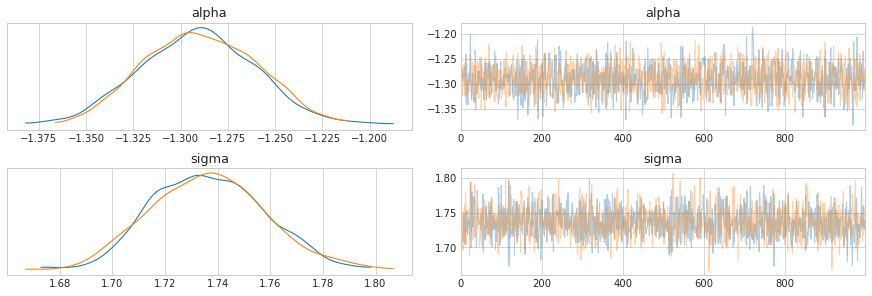

In [23]:
az.plot_trace(az_d2_m1)
plt.show()

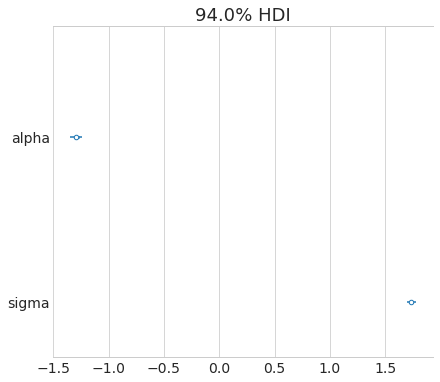

In [24]:
az.plot_forest(az_d2_m1, combined=True)
plt.show()

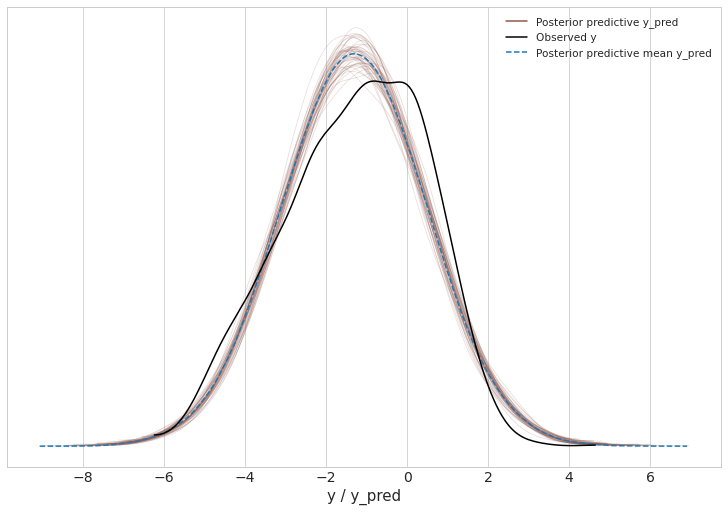

In [25]:
az.plot_ppc(az_d2_m1, data_pairs={'y':'y_pred'}, num_pp_samples=50)
plt.show()

## Model 2. Varying intercept by shRNA

$$
D_{i|s} \sim N(\mu_{i|s}, \sigma) \\
\mu = \alpha_{i|s} \\
\alpha \sim N(\mu_{\alpha}, \sigma_{\alpha}) \\
\mu_{\alpha} \sim N(0, 2) \\
\sigma_{\alpha} \sim \text{HalfCauchy}(0, 2) \\
\sigma \sim \text{HalfCauchy}(0, 5)
$$

### Generative model for a prior predictive check

In [26]:
N = 1000
S = 100
shrna_barcodes = list(range(1, S+1))
shrna_barcodes_idx = np.repeat(shrna_barcodes, N/S)

In [27]:
d2_m2_gen_data = {
    'N': N,
    'S': S,
    'shrna': shrna_barcodes_idx
}

In [28]:
d2_m2_gen_file = models_dir / 'd2_m2_generative.cpp'
d2_m2_gen = StanModel_cache(file=d2_m2_gen_file.as_posix())

Using cached StanModel.


In [29]:
d2_m2_gen_fit = d2_m2_gen.sampling(data=d2_m2_gen_data, 
                                   iter=10, warmup=0, chains=1, 
                                   algorithm='Fixed_param')

In [30]:
az_d2_m2_gen = az.from_pystan(d2_m2_gen_fit)

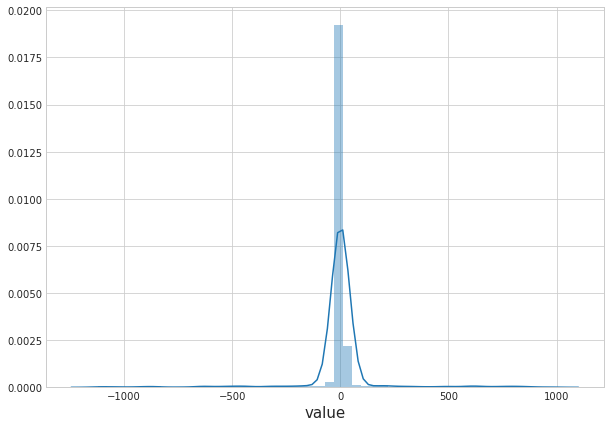

In [31]:
df = d2_m2_gen_fit.to_dataframe() \
    .drop(['chain', 'draw', 'warmup'], axis=1) \
    .melt(var_name='parameter', value_name='value')
df = df[df.parameter.str.contains('alpha\[')]
sns.distplot(df.value)
plt.show()

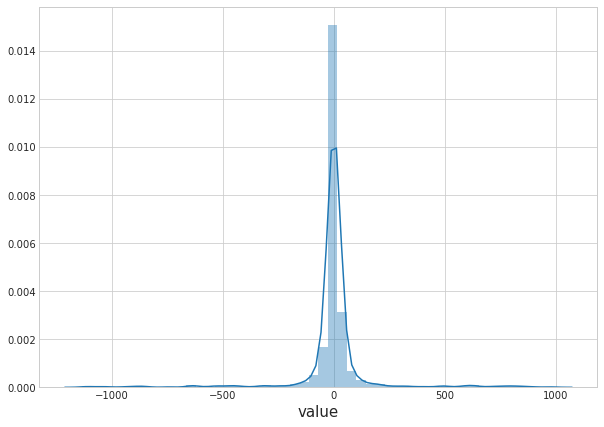

In [32]:
df = d2_m2_gen_fit.to_dataframe() \
    .drop(['chain', 'draw', 'warmup'], axis=1) \
    .melt(var_name='parameter', value_name='value')
df = df[df.parameter.str.contains('y_pred')]
sns.distplot(df.value)
plt.show()

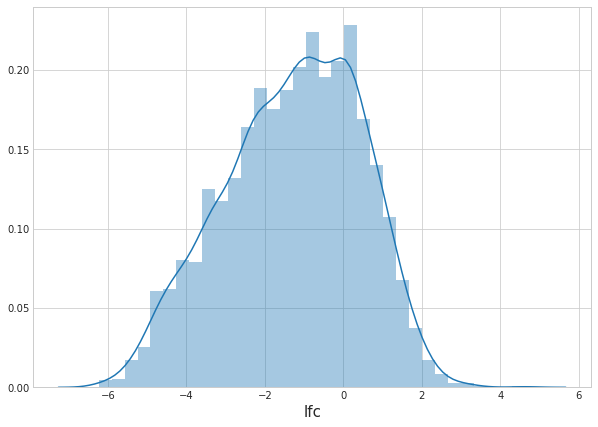

In [33]:
sns.distplot(modeling_data.lfc)
plt.show()

**Model data**

In [34]:
d2_m2_data = {
    'N': int(modeling_data.shape[0]),
    'S': np.max(modeling_data.barcode_sequence_idx),
    
    'shrna': modeling_data.barcode_sequence_idx,
    
    'y': modeling_data.lfc,
}

In [35]:
d2_m2_data['S']

109

**Compile model.**

In [36]:
d2_m2_file = models_dir / 'd2_m2.cpp'
d2_m2 = StanModel_cache(file=d2_m2_file.as_posix())

Using cached StanModel.


In [37]:
d2_m2_fit = d2_m2.sampling(data=d2_m2_data, iter=1000, chains=2)

To run all diagnostics call pystan.check_hmc_diagnostics(fit)


In [38]:
pystan.check_hmc_diagnostics(d2_m2_fit)

{'n_eff': True,
 'Rhat': True,
 'divergence': True,
 'treedepth': True,
 'energy': True}

In [39]:
az_d2_m2 = az.from_pystan(posterior=d2_m2_fit,
                          posterior_predictive='y_pred',
                          observed_data=['y'],
                          posterior_model=d2_m2)
az.summary(az_d2_m2).head()

mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_mean  \
mu_alpha    -1.220  0.121  -1.439   -1.007      0.004    0.003    1056.0   
sigma_alpha  1.277  0.087   1.121    1.446      0.003    0.002    1081.0   
alpha[0]     0.713  0.190   0.384    1.067      0.006    0.005     889.0   
alpha[1]    -0.260  0.190  -0.637    0.068      0.006    0.004    1091.0   
alpha[2]    -0.782  0.189  -1.111   -0.437      0.005    0.004    1236.0   

             ess_sd  ess_bulk  ess_tail  r_hat  
mu_alpha     1036.0    1059.0     767.0   1.00  
sigma_alpha  1075.0    1089.0     775.0   1.00  
alpha[0]      828.0     880.0     677.0   1.00  
alpha[1]      930.0    1091.0     565.0   1.00  
alpha[2]     1213.0    1240.0     815.0   1.01

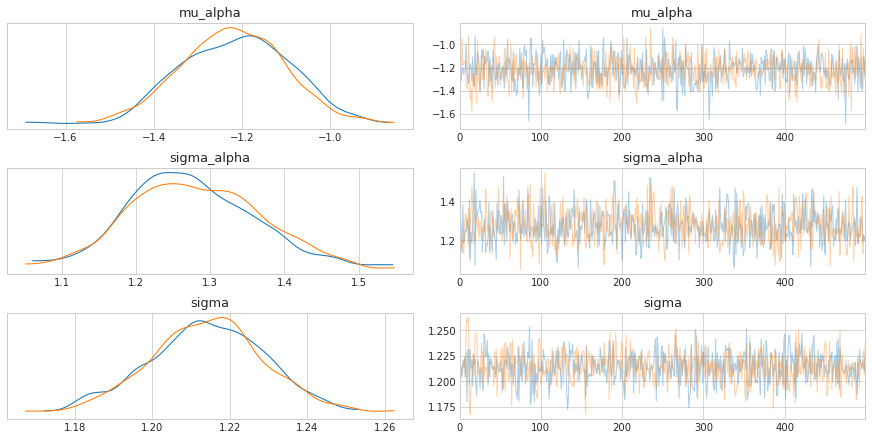

In [40]:
az.plot_trace(az_d2_m2, var_names=['mu_alpha', 'sigma_alpha', 'sigma'])
plt.show()

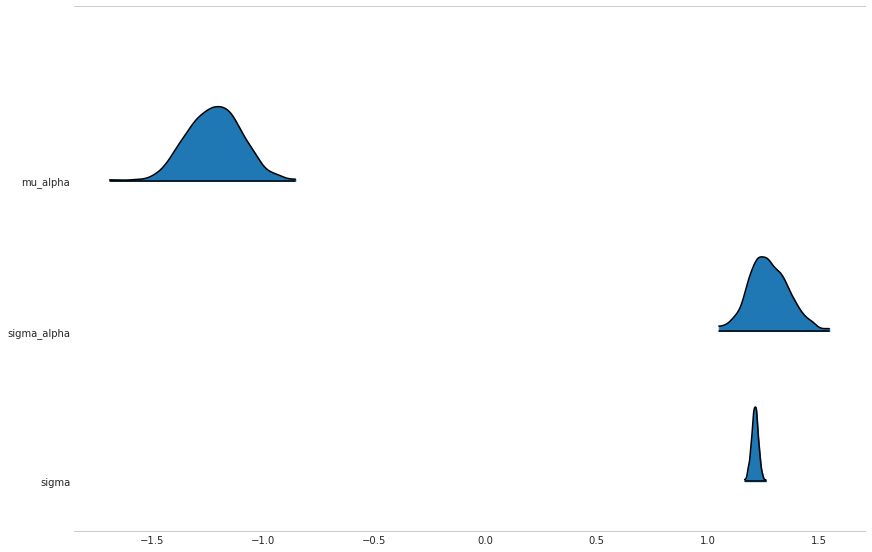

In [41]:
az.plot_forest(az_d2_m2, kind='ridgeplot', combined=True, 
               var_names=['mu_alpha', 'sigma_alpha', 'sigma'])
plt.show()

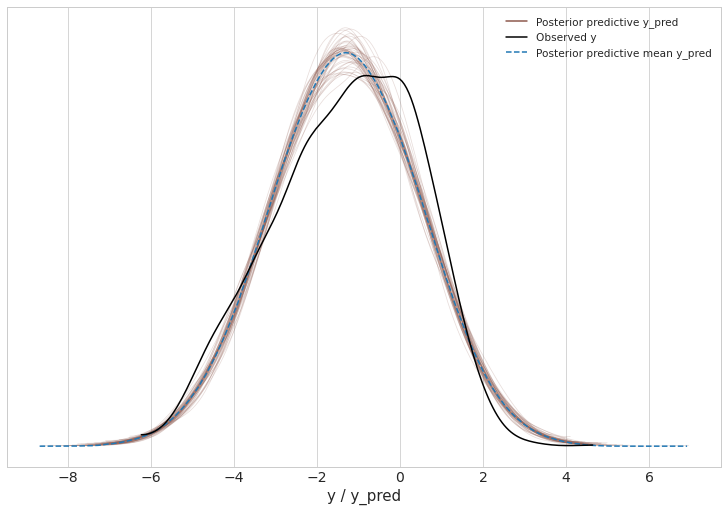

In [42]:
az.plot_ppc(az_d2_m2, data_pairs={'y':'y_pred'}, num_pp_samples=50)
plt.show()

In [43]:
d2_m2_fit.to_dataframe().head()

chain  draw  warmup  mu_alpha  sigma_alpha  alpha[1]  alpha[2]  alpha[3]  \
0      0     0       0 -1.108821     1.185056  0.985269 -0.599131 -0.573756   
1      0     1       0 -1.278377     1.310385  0.543213 -0.079502 -0.727783   
2      0     2       0 -1.310280     1.142402  0.565419 -0.314976 -0.742552   
3      0     3       0 -1.225929     1.173652  0.519321 -0.211365 -0.898190   
4      0     4       0 -1.197465     1.382379  0.876671 -0.351517 -0.774788   

   alpha[4]  alpha[5]  ...  y_pred[3332]  y_pred[3333]  y_pred[3334]  \
0  0.553302 -2.087340  ...     -3.265320     -1.491231     -2.469924   
1  0.254553 -2.451186  ...     -1.658844     -3.045479      0.772850   
2  0.092454 -2.121821  ...     -2.027082     -2.366810     -1.136287   
3  0.328518 -2.163545  ...      0.330826     -0.603705     -1.186651   
4  0.563426 -2.177239  ...     -1.269523     -0.513996     -1.844957   

          lp__  accept_stat__  stepsize__  treedepth__  n_leapfrog__  \
0 -2388.608570       0.893284    0.444461            3             7   
1 -2391.075425       0.946229    0.444461            3             7   
2 -2389.730446       0.862265    0.444461            3             7   
3 -2395.596745       0.706861    0.444461            3             7   
4 -2398.777560       0.938470    0.444461            3             7   

   divergent__     energy__  
0            0  2454.259536  
1            0  2439.358201  
2            0  2443.770573  
3            0  2452.396397  
4            0  2452.932163  

[5 rows x 3456 columns]

## Model 3. Another varying intercept for target gene

$$
D_{i|s} \sim N(\mu_{i|s}, \sigma) \\
\mu = \alpha_{i|s} + g_{i|l}\\
\alpha_s \sim N(\mu_{\alpha}, \sigma_{\alpha}) \\
g_l \sim N(\mu_g, \sigma_g) \\
\mu_{\alpha} \sim N(0, 2) \quad \sigma_{\alpha} \sim \text{HalfCauchy}(0, 10) \\
\mu_{g} \sim N(0, 2) \quad \sigma_{g} \sim \text{HalfCauchy}(0, 10) \\
\sigma \sim \text{HalfCauchy}(0, 10)
$$

In [44]:
d2_m3_data = {
    'N': int(modeling_data.shape[0]),
    'S': np.max(modeling_data.barcode_sequence_idx),
    'L': np.max(modeling_data.gene_symbol_idx),
    
    'shrna': modeling_data.barcode_sequence_idx,
    'gene': modeling_data.gene_symbol_idx,
    
    'y': modeling_data.lfc,
}

**Compile model.**

In [45]:
d2_m3_file = models_dir / 'd2_m3.cpp'
d2_m3 = StanModel_cache(file=d2_m3_file.as_posix())

Using cached StanModel.


In [46]:
d2_m3_control = {'adapt_delta': 0.99, 
                 'max_treedepth': 10}
d2_m3_fit = d2_m3.sampling(data=d2_m3_data, 
                           iter=3000, warmup=1000, chains=4, 
                           control=d2_m3_control)

To run all diagnostics call pystan.check_hmc_diagnostics(fit)


In [47]:
pystan.check_hmc_diagnostics(d2_m3_fit)

{'n_eff': True,
 'Rhat': True,
 'divergence': False,
 'treedepth': False,
 'energy': True}

In [48]:
az_d2_m3 = az.from_pystan(posterior=d2_m3_fit,
                          posterior_predictive='y_pred',
                          observed_data=['y'],
                          posterior_model=d2_m3)
az.summary(az_d2_m3).head()

mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_mean  \
mu_alpha    -0.539  1.627  -3.823    2.707      0.305    0.334      28.0   
sigma_alpha  1.236  0.093   1.071    1.417      0.004    0.003     672.0   
mu_g        -0.749  1.629  -4.015    2.477      0.305    0.339      29.0   
sigma_g      0.410  0.213   0.038    0.772      0.013    0.009     279.0   
alpha[0]     1.684  1.670  -1.632    5.013      0.302    0.273      31.0   

             ess_sd  ess_bulk  ess_tail  r_hat  
mu_alpha       12.0      32.0      20.0   1.21  
sigma_alpha   672.0     656.0    1477.0   1.00  
mu_g           12.0      32.0      20.0   1.21  
sigma_g       279.0     242.0     348.0   1.02  
alpha[0]       19.0      35.0      20.0   1.17

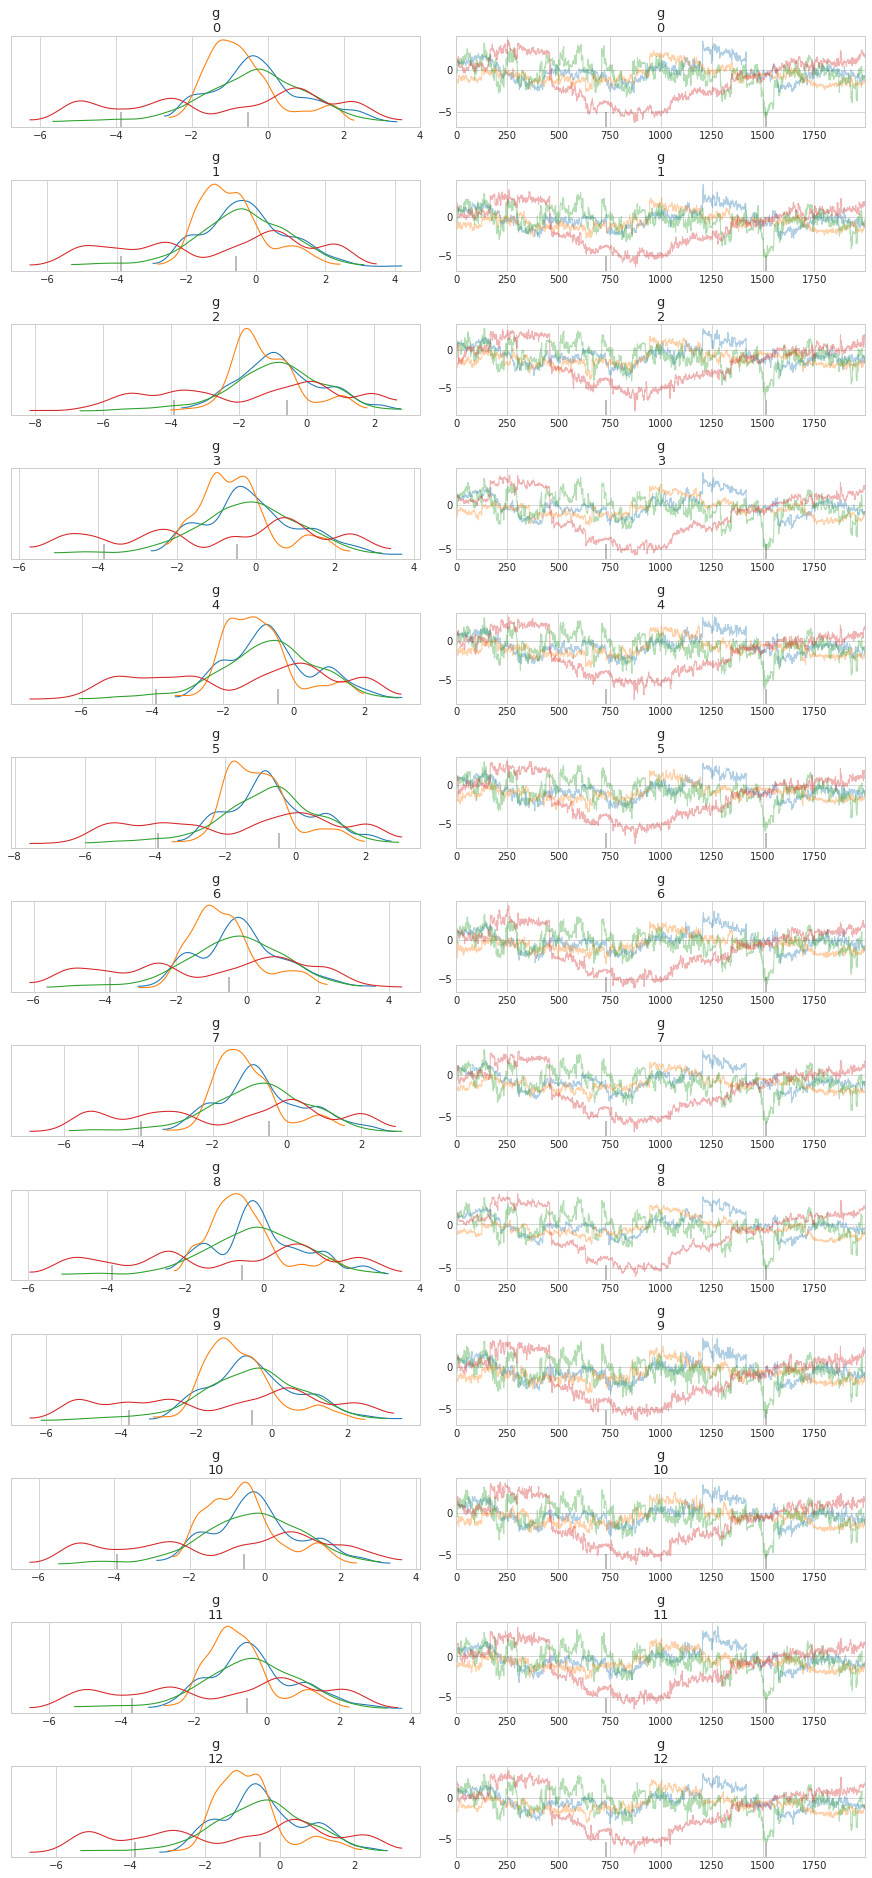

In [49]:
az.plot_trace(az_d2_m3, var_names=['g'])
plt.show()

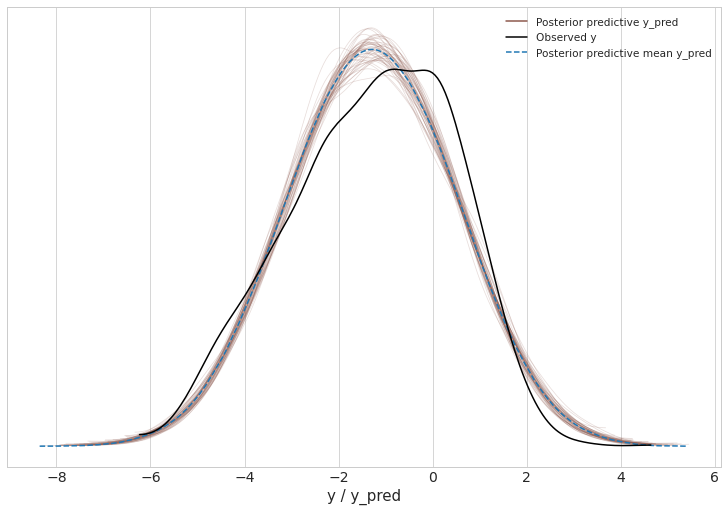

In [50]:
az.plot_ppc(az_d2_m3, data_pairs={'y':'y_pred'}, num_pp_samples=50)
plt.show()

In [51]:
fit3_summary = az.summary(az_d2_m3)

In [52]:
fit3_alpha_summary = fit3_summary[fit3_summary.index.str.contains('alpha\[')]
shrna_idx = [re.search(r"\[([A-Za-z0-9_]+)\]", a).group(1) for a in fit3_alpha_summary.index]
shrna_idx = [int(a) + 1 for a in shrna_idx]
fit3_alpha_summary = fit3_alpha_summary \
    .assign(barcode_sequence_idx = shrna_idx) \
    .set_index('barcode_sequence_idx') \
    .join(modeling_data[['barcode_sequence_idx', 'gene_symbol']] \
          .drop_duplicates() \
          .set_index('barcode_sequence_idx'))
fit3_alpha_summary.head(10)

mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  \
barcode_sequence_idx                                                      
1                     1.684  1.670  -1.632    5.013      0.302    0.273   
2                     0.313  1.673  -2.905    3.848      0.308    0.367   
3                     0.186  1.672  -3.290    3.379      0.302    0.367   
4                     0.716  1.658  -2.553    4.147      0.304    0.332   
5                    -1.095  1.689  -4.599    2.066      0.306    0.233   
6                    -0.470  1.658  -3.967    2.728      0.306    0.347   
7                    -0.230  1.671  -3.575    3.206      0.309    0.373   
8                     1.487  1.668  -2.038    4.717      0.309    0.293   
9                     0.669  1.675  -2.770    4.044      0.310    0.351   
10                   -0.492  1.675  -3.839    2.827      0.309    0.336   

                      ess_mean  ess_sd  ess_bulk  ess_tail  r_hat gene_symbol  
barcode_sequence_idx                                                           
1                         31.0    19.0      35.0      20.0   1.17        EIF6  
2                         29.0    11.0      33.0      20.0   1.19        GRK5  
3                         31.0    11.0      35.0      20.0   1.18        EIF6  
4                         30.0    13.0      33.0      20.0   1.18        EGFR  
5                         31.0    27.0      35.0      21.0   1.17      COL8A1  
6                         29.0    12.0      34.0      19.0   1.20        KRAS  
7                         29.0    11.0      33.0      19.0   1.20        PTK2  
8                         29.0    17.0      33.0      19.0   1.20        PTK2  
9                         29.0    12.0      33.0      19.0   1.20        PTK2  
10                        29.0    13.0      33.0      19.0   1.19        BRAF

In [53]:
fit3_gene_summary = fit3_summary[fit3_summary.index.str.contains('g\[')]
gene_idx = [re.search(r"\[([A-Za-z0-9_]+)\]", a).group(1) for a in fit3_gene_summary.index]
gene_idx = [int(a) + 1 for a in gene_idx]
fit3_gene_summary = fit3_gene_summary \
    .assign(gene_symbol_idx = gene_idx) \
    .set_index('gene_symbol_idx') \
    .join(modeling_data[['gene_symbol_idx', 'gene_symbol']] \
          .drop_duplicates() \
          .set_index('gene_symbol_idx')) \
    .reset_index(drop=False)
fit3_gene_summary.head(10)

gene_symbol_idx   mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  \
0                1 -0.615  1.667  -3.996    2.648      0.310    0.348   
1                2 -0.641  1.660  -4.058    2.589      0.308    0.346   
2                3 -1.163  1.679  -4.189    2.400      0.306    0.310   
3                4 -0.463  1.640  -4.016    2.677      0.305    0.354   
4                5 -0.974  1.662  -4.193    2.374      0.302    0.317   
5                6 -1.024  1.673  -4.273    2.412      0.306    0.326   
6                7 -0.569  1.665  -4.101    2.615      0.309    0.352   
7                8 -1.036  1.647  -4.135    2.414      0.306    0.325   
8                9 -0.449  1.651  -3.496    3.133      0.309    0.365   
9               10 -0.801  1.672  -4.016    2.787      0.308    0.342   

   ess_mean  ess_sd  ess_bulk  ess_tail  r_hat gene_symbol  
0      29.0    12.0      33.0      19.0   1.20        BRAF  
1      29.0    12.0      33.0      20.0   1.19        COG3  
2      30.0    15.0      34.0      21.0   1.17      COL8A1  
3      29.0    11.0      33.0      20.0   1.20        EGFR  
4      30.0    14.0      34.0      20.0   1.18        EIF6  
5      30.0    14.0      34.0      19.0   1.18       ESPL1  
6      29.0    12.0      33.0      20.0   1.19        GRK5  
7      29.0    13.0      33.0      19.0   1.20        KRAS  
8      29.0    11.0      32.0      18.0   1.21        PTK2  
9      29.0    13.0      33.0      20.0   1.19       RC3H2

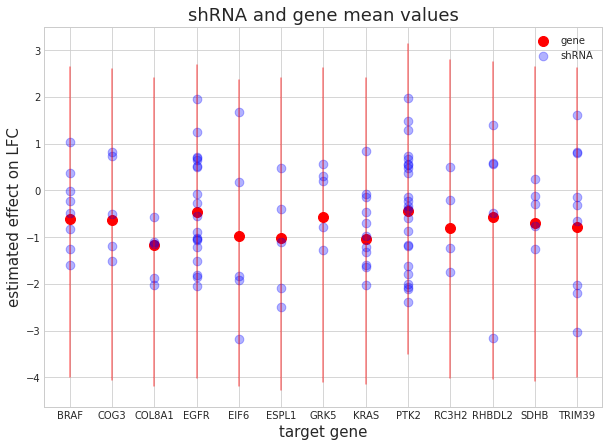

In [55]:
for i in range(fit3_gene_summary.shape[0]):
    plt.plot(np.repeat(fit3_gene_summary.loc[i, 'gene_symbol'], 2), 
             [fit3_gene_summary.loc[i, 'hdi_3%'], fit3_gene_summary.loc[i, 'hdi_97%']],
             color='red', alpha=0.5)


plt.scatter(fit3_gene_summary['gene_symbol'], 
            fit3_gene_summary['mean'],
            s=100, c='r', label='gene')
plt.scatter(fit3_alpha_summary['gene_symbol'], 
            fit3_alpha_summary['mean'], 
            alpha=0.3, s=75, c='b', label='shRNA')

plt.title('shRNA and gene mean values')
plt.xlabel('target gene')
plt.ylabel('estimated effect on LFC')
plt.legend()
plt.show()

## Model 4. Parameters for difference between average gene effect and cell line-specific effect

Note that the varying intercept for shRNA has been renamed from $\alpha$ to $c$.
$\bar g_{l}$ is the average effect of knocking-down gene $l$ while $g_{jl}$ is the cell line $j$-specific effect of knocking-down $l$.

There is now also varying population level standard deviations for each shRNA $\sigma_s$.
This seems to help reduce divergences during sampling by modeling differences in standard deviation for each shRNA.

$$
D_{i|s} \sim N(\mu_{i|s}, \sigma_s) \\
\mu = c_{i|s} + \bar g_{i|l} + g_{i|jl} \\
c_s \sim N(0, \sigma_c) \\
\bar g_l \sim N(\mu_{\bar g}, \sigma_{\bar g}) \\
g_{jl} \sim N(0, \sigma_g) \\
\sigma_c \sim \text{HalfNormal}(0, 3) \\
\mu_{\bar g} \sim N(0, 2) \quad \sigma_{\bar g} \sim \text{HalfNormal}(0, 10) \\
\sigma_g \sim \text{HalfNormal}(0, 5) \\
\sigma_s \sim \text{HalfNormal}(\mu_\sigma, \sigma_\sigma) \\
\mu_\sigma \sim \text{HalfNormal}(0, 2) \quad \sigma_\sigma \sim \text{HalfNormal}(0, 1) \\
$$

In [56]:
d2_m4_data = {
    'N': int(modeling_data.shape[0]),
    'S': np.max(modeling_data.barcode_sequence_idx),
    'L': np.max(modeling_data.gene_symbol_idx),
    'J': np.max(modeling_data.cell_line_idx),
    
    'shrna': modeling_data.barcode_sequence_idx,
    'gene': modeling_data.gene_symbol_idx,
    'cell_line': modeling_data.cell_line_idx,
    
    'y': modeling_data.lfc,
}

**Compile model.**

In [57]:
d2_m4_file = models_dir / 'd2_m4.cpp'
d2_m4 = StanModel_cache(file=d2_m4_file.as_posix())

Using cached StanModel.


In [58]:
d2_m4_control = {'adapt_delta': 0.99, 
                 'max_treedepth': 10}
d2_m4_fit = d2_m4.sampling(data=d2_m4_data, 
                           iter=3000, warmup=1000, chains=4, 
                           control=d2_m4_control)

To run all diagnostics call pystan.check_hmc_diagnostics(fit)


In [59]:
pystan.check_hmc_diagnostics(d2_m4_fit)

{'n_eff': True,
 'Rhat': True,
 'divergence': False,
 'treedepth': True,
 'energy': True}

In [60]:
az_d2_m4 = az.from_pystan(posterior=d2_m4_fit,
                          posterior_predictive='y_pred',
                          observed_data=['y'],
                          posterior_model=d2_m4)
az.summary(az_d2_m4).head()

mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_mean  \
sigma_c     1.236  0.091   1.073    1.411      0.001    0.001    6320.0   
mu_gbar    -1.274  0.189  -1.616   -0.896      0.005    0.003    1758.0   
sigma_gbar  0.421  0.213   0.040    0.790      0.008    0.006     708.0   
sigma_g     0.460  0.031   0.401    0.519      0.001    0.000    2405.0   
c[0]        2.269  0.400   1.557    3.044      0.010    0.007    1683.0   

            ess_sd  ess_bulk  ess_tail  r_hat  
sigma_c     6130.0    6572.0    5787.0    1.0  
mu_gbar     1758.0    1713.0    3476.0    1.0  
sigma_gbar   708.0     626.0     671.0    1.0  
sigma_g     2405.0    2402.0    4668.0    1.0  
c[0]        1636.0    1747.0    3186.0    1.0

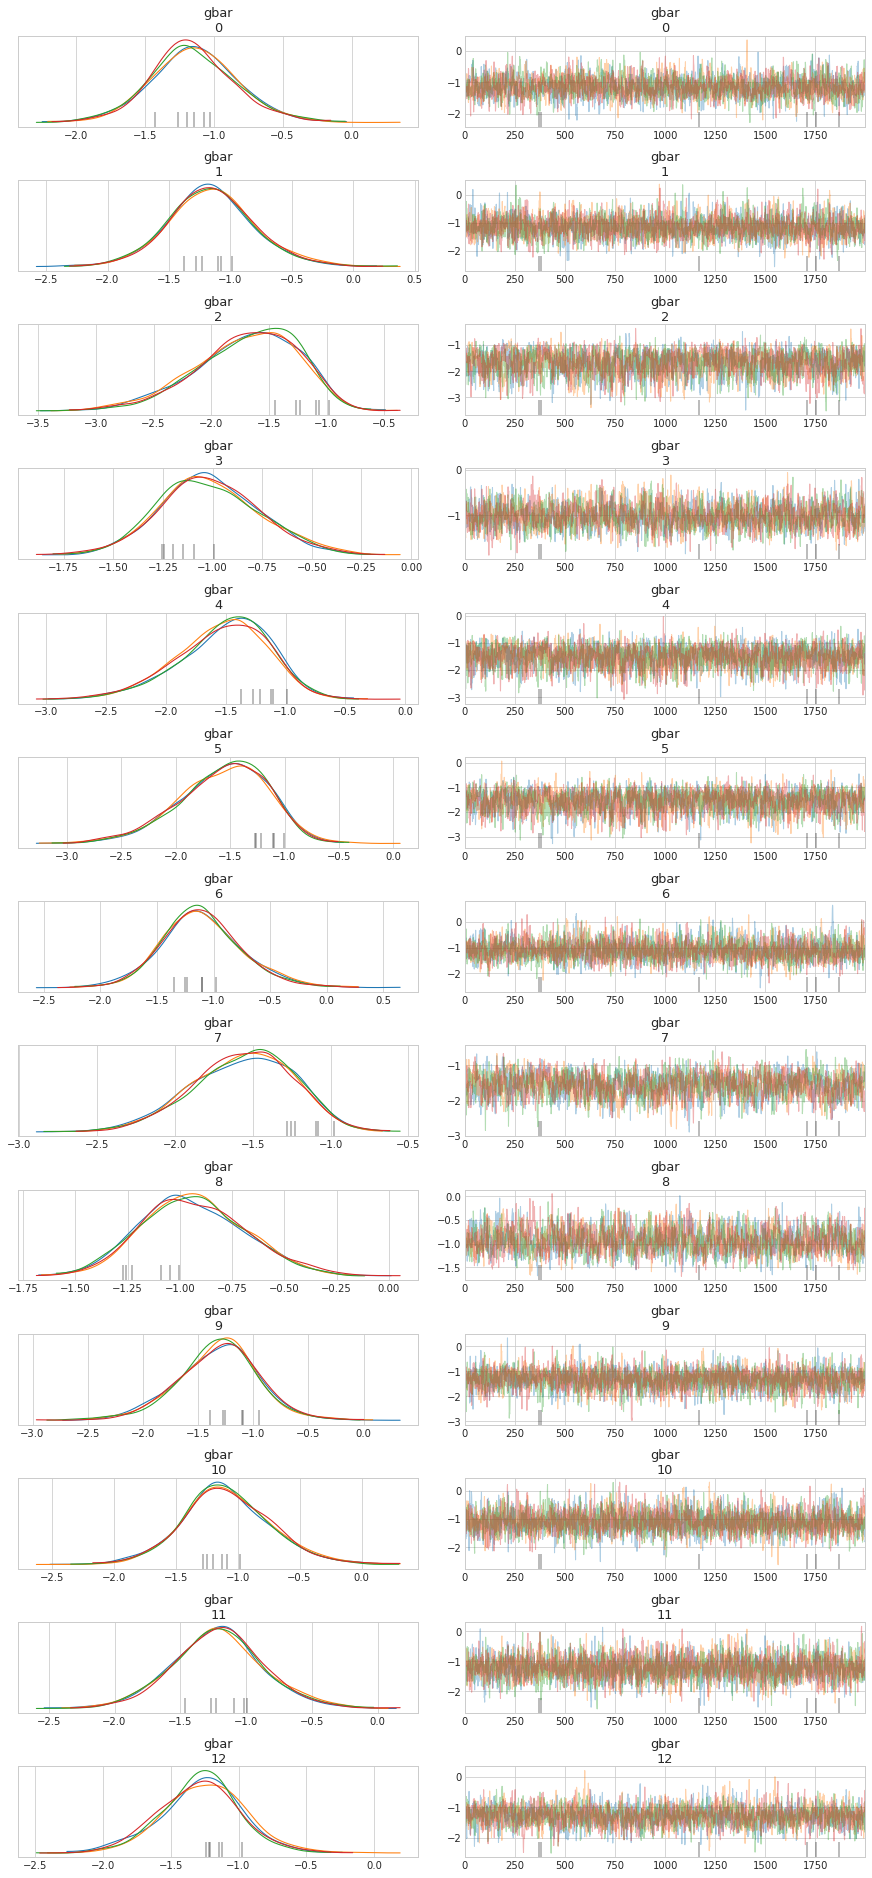

In [61]:
az.plot_trace(az_d2_m4, var_names=['gbar'])
plt.show()

In [62]:
az.summary(az_d2_m4).tail()

mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_mean  \
sigma[104]  1.039  0.138   0.787    1.298      0.001    0.001   14883.0   
sigma[105]  0.981  0.113   0.770    1.191      0.001    0.001   13297.0   
sigma[106]  1.208  0.131   0.963    1.457      0.001    0.001   16877.0   
sigma[107]  1.053  0.135   0.802    1.314      0.001    0.001   17297.0   
sigma[108]  1.083  0.139   0.833    1.353      0.001    0.001   15266.0   

             ess_sd  ess_bulk  ess_tail  r_hat  
sigma[104]  14251.0   14826.0    6073.0    1.0  
sigma[105]  13020.0   13293.0    5934.0    1.0  
sigma[106]  15843.0   17234.0    5944.0    1.0  
sigma[107]  15814.0   17722.0    5577.0    1.0  
sigma[108]  14346.0   15353.0    5851.0    1.0

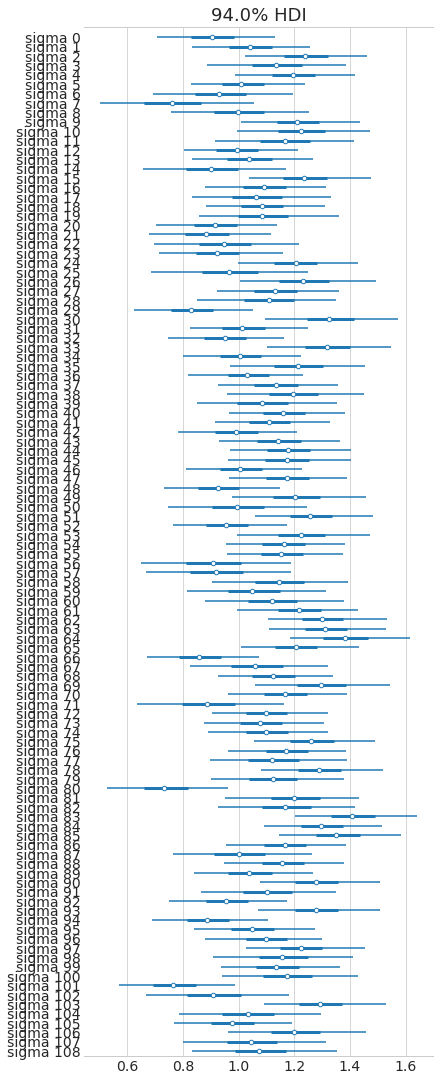

In [63]:
az.plot_forest(az_d2_m4, var_names=['sigma'], combined=True)
plt.show()

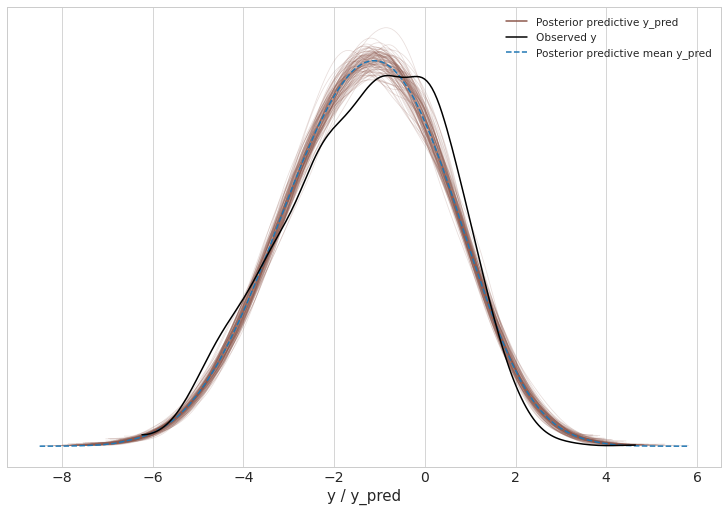

In [64]:
az.plot_ppc(az_d2_m4, data_pairs={'y':'y_pred'}, num_pp_samples=100)
plt.show()

In [65]:
g_jl_post = d2_m4_fit.to_dataframe() \
    .melt(id_vars=['chain', 'draw', 'warmup']) \
    .pipe(lambda d: d[d.variable.str.contains('g\[')])

In [66]:
g_jl_post.head()

chain  draw  warmup variable     value
1008000      0     0       0   g[1,1] -0.221500
1008001      0     1       0   g[1,1]  0.824350
1008002      0     2       0   g[1,1] -0.084794
1008003      0     3       0   g[1,1]  0.425565
1008004      0     4       0   g[1,1]  0.283258

In [67]:
def extract_g_index(s, i=0, outside_text='g[]'):
    s_mod = [a.strip(outside_text) for a in s]
    s_mod = [a.split(',') for a in s_mod]
    s_mod = [a[i].strip() for a in s_mod]
    return s_mod

In [68]:
g_jl_post = g_jl_post \
    .assign(cell_line_idx=lambda x: extract_g_index(x.variable.to_list(), i=0),
            gene_symbol_idx=lambda x: extract_g_index(x.variable.to_list(), i=1)) \
    .astype({'cell_line_idx': int, 'gene_symbol_idx': int}) \
    .groupby(['cell_line_idx', 'gene_symbol_idx']) \
    .mean() \
    .reset_index() \
    .astype({'cell_line_idx': int, 'gene_symbol_idx': int}) \
    .set_index('cell_line_idx') \
    .join(modeling_data[['cell_line', 'cell_line_idx']] \
              .drop_duplicates() \
              .astype({'cell_line_idx': int}) \
              .set_index('cell_line_idx'),
          how='left') \
    .reset_index() \
    .set_index('gene_symbol_idx') \
    .join(modeling_data[['gene_symbol', 'gene_symbol_idx']] \
              .drop_duplicates() \
              .astype({'gene_symbol_idx': int}) \
              .set_index('gene_symbol_idx'),
          how='left') \
    .reset_index() \
    .assign(gene_symbol=lambda x: [f'{a} ({b})' for a,b in zip(x.gene_symbol, x.gene_symbol_idx)],
            cell_line=lambda x: [f'{a} ({b})' for a,b in zip(x.cell_line, x.cell_line_idx)]) \
    .drop(['gene_symbol_idx', 'cell_line_idx'], axis=1) \
    .pivot(index='gene_symbol', columns='cell_line', values='value')

In [69]:
from scipy.cluster import hierarchy
from scipy.spatial import distance

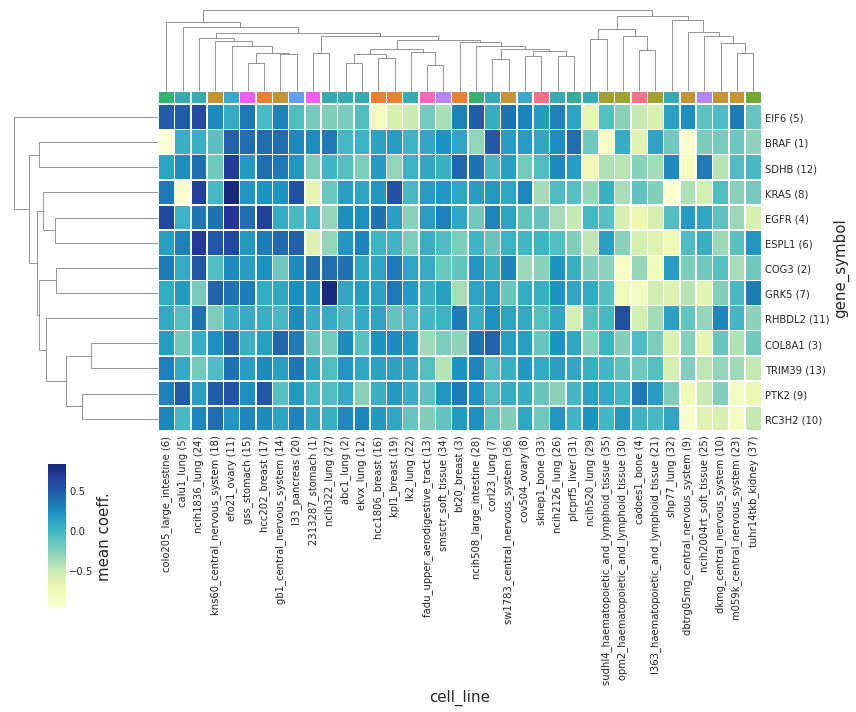

In [70]:
# Color bar for tissue of origin of cell lines.
cell_line_origin = g_jl_post.columns.to_list()
cell_line_origin = [a.split(' ')[0] for a in cell_line_origin]
cell_line_origin = [a.split('_')[1:] for a in cell_line_origin]
cell_line_origin = [' '.join(a) for a in cell_line_origin]

cell_line_pal = sns.husl_palette(len(np.unique(cell_line_origin)), s=.90)
cell_line_lut = dict(zip(np.unique(cell_line_origin), cell_line_pal))

cell_line_colors = pd.Series(cell_line_origin, index=g_jl_post.columns).map(cell_line_lut)

np.random.seed(123)
row_linkage = hierarchy.linkage(distance.pdist(g_jl_post), method='average')

p = sns.clustermap(g_jl_post, center=0, cmap="YlGnBu", linewidths=0.5, 
                   figsize=(12, 10),
                   cbar_kws={'label': 'mean coeff.'},
                   cbar_pos=[0.06, 0.15, 0.02, 0.2],
                   row_linkage=row_linkage,
                   col_colors=cell_line_colors)

In [71]:
d2_m4_post = d2_m4_fit.to_dataframe()

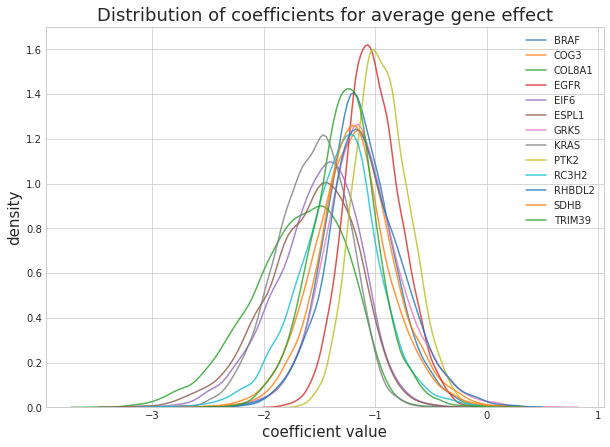

In [72]:
genes_post = d2_m4_post.loc[:, d2_m4_post.columns.str.contains('gbar\[')]

genes = list(np.unique(modeling_data.gene_symbol))
genes.sort()
genes_post.columns = genes

for col in genes_post.columns.to_list():
    sns.distplot(genes_post[[col]], hist=False, label=col, kde_kws={'shade': False, 'alpha': 0.8})

plt.legend()
plt.xlabel('coefficient value')
plt.ylabel('density')
plt.title('Distribution of coefficients for average gene effect')
plt.show()

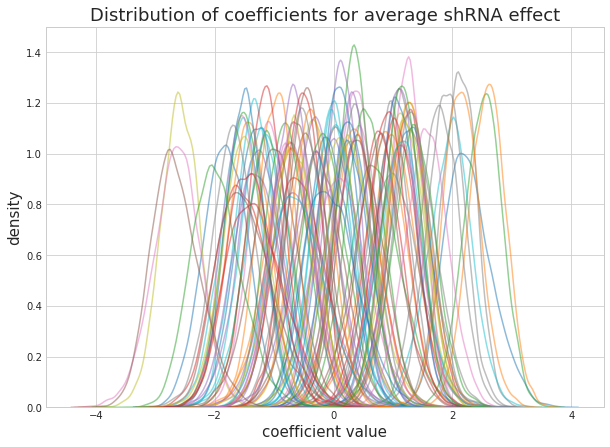

In [73]:
cell_lines_post = d2_m4_post.loc[:, d2_m4_post.columns.str.contains('c\[')]

for col in cell_lines_post.columns.to_list():
    sns.distplot(cell_lines_post[[col]], hist=False, kde_kws={'shade': False, 'alpha': 0.5})

plt.xlabel('coefficient value')
plt.ylabel('density')
plt.title('Distribution of coefficients for average shRNA effect')
plt.show()

## Model 5. Multiplicative scaling factor of each shRNA

In the original DEMETER2 paper, the model includes a multiplicative scaling factor for each shRNA, constrained between 0 and 1, along with the addative varying effect for each shRNA.
The factor is multiplied against the gene effect.

In this model, I experiment with this multiplicative factor $\alpha_s$.

**Still need to adjust the model below.**

$$
D_{i|s} \sim N(\mu_{i|s}, \sigma_s) \\
\mu = c_{i|s} + \alpha_s (\bar g_{i|l} + g_{i|jl}) \\
c_s \sim N(0, \sigma_c) \\
\alpha_s \sim \text{Uniform}(0, 1) \\
\bar g_l \sim N(\mu_{\bar g}, \sigma_{\bar g}) \\
g_{jl} \sim N(0, \sigma_g) \\
\sigma_c \sim \text{HalfNormal}(0, 3) \\
\mu_{\bar g} \sim N(0, 2) \quad \sigma_{\bar g} \sim \text{HalfNormal}(0, 10) \\
\sigma_g \sim \text{HalfNormal}(0, 5) \\
\sigma_s \sim \text{HalfNormal}(\mu_\sigma, \sigma_\sigma) \\
\mu_\sigma \sim \text{HalfNormal}(0, 2) \quad \sigma_\sigma \sim \text{HalfNormal}(0, 1) \\
$$

In [74]:
d2_m5_data = {
    'N': int(modeling_data.shape[0]),
    'S': np.max(modeling_data.barcode_sequence_idx),
    'L': np.max(modeling_data.gene_symbol_idx),
    'J': np.max(modeling_data.cell_line_idx),
    
    'shrna': modeling_data.barcode_sequence_idx,
    'gene': modeling_data.gene_symbol_idx,
    'cell_line': modeling_data.cell_line_idx,
    
    'y': modeling_data.lfc,
}

**Compile model.**

In [75]:
d2_m5_file = models_dir / 'd2_m5.cpp'
d2_m5 = StanModel_cache(file=d2_m5_file.as_posix())

Using cached StanModel.


In [76]:
d2_m5_control = {'adapt_delta': 0.99, 
                 'max_treedepth': 10}
d2_m5_fit = d2_m5.sampling(data=d2_m5_data, 
                           iter=3000, warmup=1000, chains=4, 
                           control=d2_m5_control)

To run all diagnostics call pystan.check_hmc_diagnostics(fit)


In [77]:
pystan.check_hmc_diagnostics(d2_m5_fit)

{'n_eff': True,
 'Rhat': True,
 'divergence': False,
 'treedepth': False,
 'energy': True}

In [78]:
d2_m5_post = d2_m5_fit.to_dataframe()

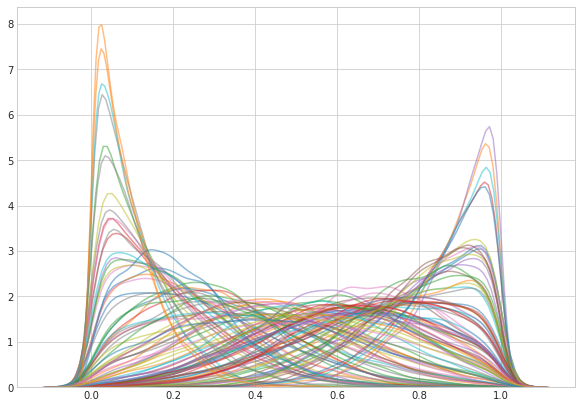

In [79]:
df = d2_m5_post.loc[:, d2_m5_post.columns.str.contains('alpha\[')]
for col in df.columns:
    sns.distplot(df[[col]], hist=False, kde_kws={'alpha': 0.5})

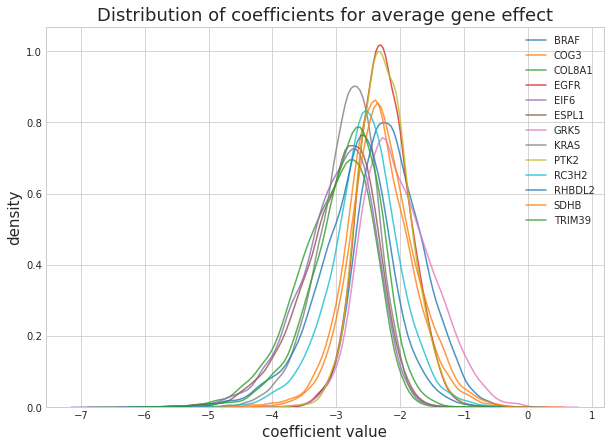

In [80]:
genes_post = d2_m5_post.loc[:, d2_m5_post.columns.str.contains('gbar\[')]

genes = list(np.unique(modeling_data.gene_symbol))
genes.sort()
genes_post.columns = genes

for col in genes_post.columns.to_list():
    sns.distplot(genes_post[[col]], hist=False, label=col, kde_kws={'shade': False, 'alpha': 0.8})

plt.legend()
plt.xlabel('coefficient value')
plt.ylabel('density')
plt.title('Distribution of coefficients for average gene effect')
plt.show()

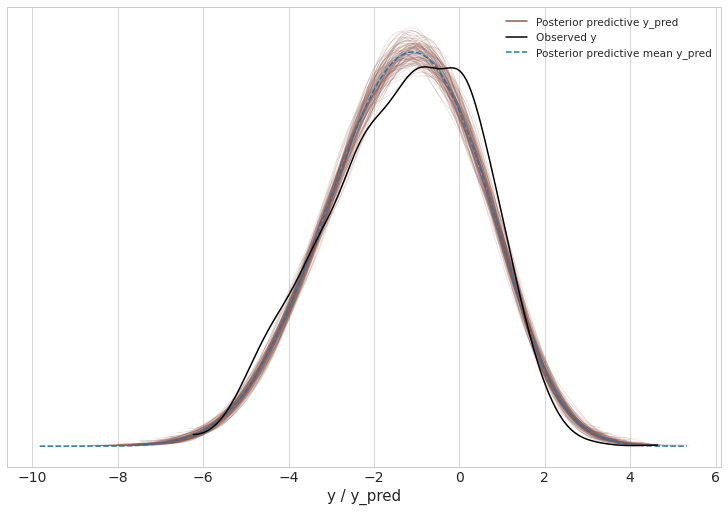

In [81]:
az_d2_m5 = az.from_pystan(posterior=d2_m5_fit,
                          posterior_predictive='y_pred',
                          observed_data=['y'],
                          posterior_model=d2_m5)
az.plot_ppc(az_d2_m5, data_pairs={'y':'y_pred'}, num_pp_samples=100)
plt.show()

In [82]:
g_jl_post = d2_m5_fit.to_dataframe() \
    .melt(id_vars=['chain', 'draw', 'warmup']) \
    .pipe(lambda d: d[d.variable.str.contains('g\[')])

In [83]:
g_jl_post = g_jl_post \
    .assign(cell_line_idx=lambda x: extract_g_index(x.variable.to_list(), i=0),
            gene_symbol_idx=lambda x: extract_g_index(x.variable.to_list(), i=1)) \
    .astype({'cell_line_idx': int, 'gene_symbol_idx': int}) \
    .groupby(['cell_line_idx', 'gene_symbol_idx']) \
    .mean() \
    .reset_index() \
    .astype({'cell_line_idx': int, 'gene_symbol_idx': int}) \
    .set_index('cell_line_idx') \
    .join(modeling_data[['cell_line', 'cell_line_idx']] \
              .drop_duplicates() \
              .astype({'cell_line_idx': int}) \
              .set_index('cell_line_idx'),
          how='left') \
    .reset_index() \
    .set_index('gene_symbol_idx') \
    .join(modeling_data[['gene_symbol', 'gene_symbol_idx']] \
              .drop_duplicates() \
              .astype({'gene_symbol_idx': int}) \
              .set_index('gene_symbol_idx'),
          how='left') \
    .reset_index() \
    .assign(gene_symbol=lambda x: [f'{a} ({b})' for a,b in zip(x.gene_symbol, x.gene_symbol_idx)],
            cell_line=lambda x: [f'{a} ({b})' for a,b in zip(x.cell_line, x.cell_line_idx)]) \
    .drop(['gene_symbol_idx', 'cell_line_idx'], axis=1) \
    .pivot(index='gene_symbol', columns='cell_line', values='value')

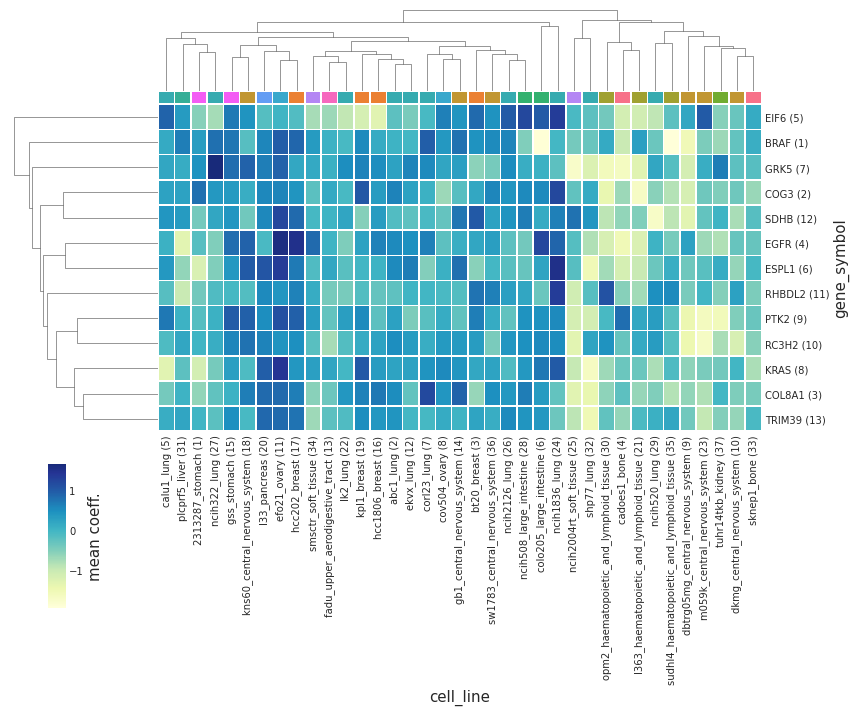

In [84]:
# Color bar for tissue of origin of cell lines.
cell_line_origin = g_jl_post.columns.to_list()
cell_line_origin = [a.split(' ')[0] for a in cell_line_origin]
cell_line_origin = [a.split('_')[1:] for a in cell_line_origin]
cell_line_origin = [' '.join(a) for a in cell_line_origin]

cell_line_pal = sns.husl_palette(len(np.unique(cell_line_origin)), s=.90)
cell_line_lut = dict(zip(np.unique(cell_line_origin), cell_line_pal))

cell_line_colors = pd.Series(cell_line_origin, index=g_jl_post.columns).map(cell_line_lut)

np.random.seed(123)
row_linkage = hierarchy.linkage(distance.pdist(g_jl_post), method='average')

p = sns.clustermap(g_jl_post, center=0, cmap="YlGnBu", linewidths=0.5, 
                   figsize=(12, 10),
                   cbar_kws={'label': 'mean coeff.'},
                   cbar_pos=[0.06, 0.15, 0.02, 0.2],
                   row_linkage=row_linkage,
                   col_colors=cell_line_colors)

In [85]:
y_pred = d2_m5_fit.extract(pars='y_pred')['y_pred']
y_pred.shape

(8000, 3334)

In [108]:
m5_pred_mean = np.apply_along_axis(np.mean, 0, y_pred)
m5_pred_hdi = np.apply_along_axis(az.hdi, 0, y_pred, hdi_prob=0.89)
d2_m5_pred = pd.DataFrame({
    'pred_mean': m5_pred_mean, 
    'pred_hdi_low': m5_pred_hdi[0], 
    'pred_hdi_high': m5_pred_hdi[1],
    'obs': d2_m5_data['y'],
    'barcode_sequence_idx': d2_m5_data['shrna'],
    'gene_idx': d2_m5_data['gene'],
    'cell_line_idx': d2_m5_data['cell_line'],
    'barcode_sequence': modeling_data.barcode_sequence,
    'gene_symbol': modeling_data.gene_symbol,
    'cell_line': modeling_data.cell_line,
})
d2_m5_pred

pred_mean  pred_hdi_low  pred_hdi_high       obs  barcode_sequence_idx  \
0      0.744667     -0.791694       2.297316  0.625725                     1   
1      0.777470     -0.741794       2.363685  2.145082                     1   
2      0.931287     -0.641638       2.469319  0.932751                     1   
3      0.855988     -0.705009       2.446985  1.372030                     1   
4      0.854054     -0.683342       2.480360  0.803835                     1   
...         ...           ...            ...       ...                   ...   
3329  -1.835425     -3.672325       0.045855 -3.118520                   109   
3330  -1.085971     -2.869447       0.766869 -1.858803                   109   
3331  -1.418879     -3.182395       0.406587 -2.398997                   109   
3332  -0.896747     -2.735280       0.870756  0.948492                   109   
3333  -1.337944     -3.144455       0.472829 -2.847713                   109   

      gene_idx  cell_line_idx       barcode_sequence gene_symbol  \
0            5             11  ACAGAAGAAATTCTGGCAGAT        EIF6   
1            5              9  ACAGAAGAAATTCTGGCAGAT        EIF6   
2            5              3  ACAGAAGAAATTCTGGCAGAT        EIF6   
3            5             36  ACAGAAGAAATTCTGGCAGAT        EIF6   
4            5             18  ACAGAAGAAATTCTGGCAGAT        EIF6   
...        ...            ...                    ...         ...   
3329        13             32  TGCTCTCATGGGTCTAGATAT      TRIM39   
3330        13             33  TGCTCTCATGGGTCTAGATAT      TRIM39   
3331        13             34  TGCTCTCATGGGTCTAGATAT      TRIM39   
3332        13             35  TGCTCTCATGGGTCTAGATAT      TRIM39   
3333        13             37  TGCTCTCATGGGTCTAGATAT      TRIM39   

                                      cell_line  
0                                   efo21_ovary  
1              dbtrg05mg_central_nervous_system  
2                                   bt20_breast  
3                 sw1783_central_nervous_system  
4                  kns60_central_nervous_system  
...                                         ...  
3329                                 shp77_lung  
3330                                sknep1_bone  
3331                         smsctr_soft_tissue  
3332  sudhl4_haematopoietic_and_lymphoid_tissue  
3333                           tuhr14tkb_kidney  

[3334 rows x 10 columns]

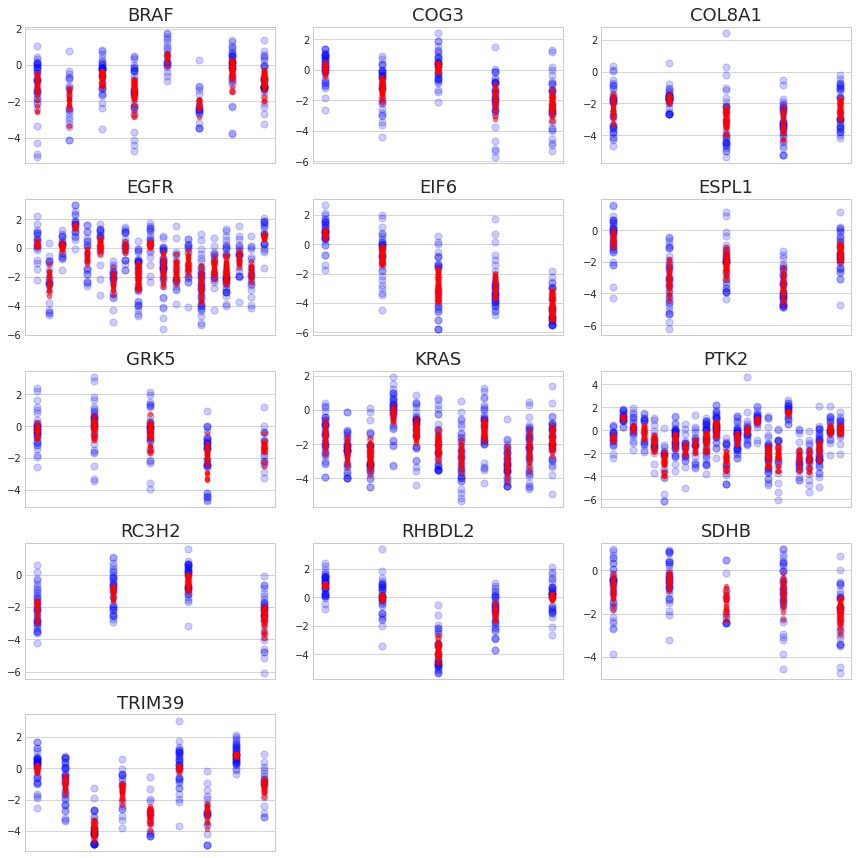

In [122]:
genes = list(np.unique(d2_m5_pred.gene_symbol))
genes.sort()

fig, axes = plt.subplots(5, 3, figsize=(12, 12))

for ax, gene in zip(axes.flatten(), genes):
    df = d2_m5_pred[d2_m5_pred.gene_symbol == gene]
    ax.scatter(df.barcode_sequence, df.obs, color='blue', s=50, alpha=0.2)
    ax.scatter(df.barcode_sequence, df.pred_mean, color='red', s=20, alpha=0.5)
    ax.xaxis.set_ticks([])
    ax.set_title(gene)


axes[4, 2].axis('off')
axes[4, 1].axis('off')
fig.tight_layout(pad=1.0)
plt.show()

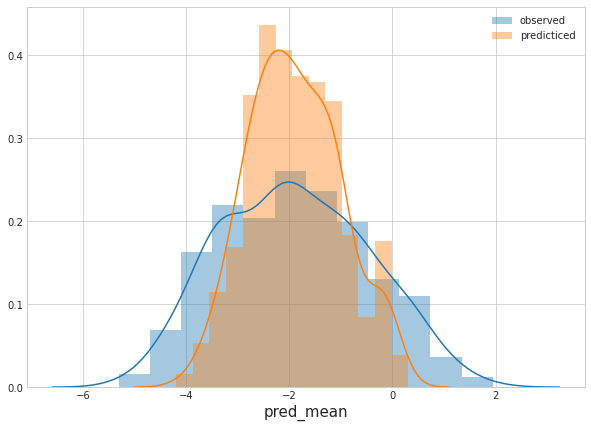

In [127]:
sns.distplot(d2_m5_pred[d2_m5_pred.gene_symbol == 'KRAS'].obs, label='observed')
sns.distplot(d2_m5_pred[d2_m5_pred.gene_symbol == 'KRAS'].pred_mean, label='predicticed')
plt.legend()
plt.show()

**TODO: analyze "gene effect" of knocking out KRAS in each cell line.**
Should see a difference when KRAS is mutated.

In [128]:
y_pred = d2_m5_fit.extract(pars='g')['g']
y_pred.shape

(8000, 37, 13)

In [129]:
y_pred

array([[[ 0.17030466, -0.05721729,  0.09751464, ..., -0.56632996,
          0.37246704,  0.071092  ],
        [-0.20250775,  0.13320934,  0.40800104, ..., -0.32288757,
         -1.01224692,  0.6296203 ],
        [ 0.44411325, -0.0753678 , -2.39095323, ...,  1.17328341,
          1.21650331,  0.33234875],
        ...,
        [-3.58798989, -0.97525687,  0.28062385, ...,  1.02593927,
         -0.44228613, -1.17009598],
        [-0.5739497 ,  0.75430482,  0.68115406, ...,  0.73258662,
          0.57047193,  0.06020884],
        [-0.59875139, -0.95259389,  0.48860447, ..., -1.40549786,
          0.31242392,  0.01882788]],

       [[-0.19797602,  0.8788721 , -1.21573669, ..., -0.65996724,
         -0.01337243, -0.56771174],
        [ 0.08371367,  0.24074918,  1.05680169, ..., -0.58325058,
         -0.8076319 , -0.34551674],
        [ 0.65669334,  1.76092819, -0.71335445, ...,  0.9360845 ,
          1.36733437,  0.18945618],
        ...,
        [-1.67771993, -0.71017835, -0.85227107, ..., -